In [34]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
DATA = "data/matches_ml_prematch_clean.csv"
df = pd.read_csv(DATA)
print("Loaded:", df.shape)

# Target/Features (keep match_id for grouped split)
y = df["label"].astype(int)
X = df.drop(columns=["label"])


Loaded: (42703, 15)


In [30]:
# Grouped split by match_id to keep both orientations together
groups = X["match_id"]
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train = X.iloc[train_idx].drop(columns=["match_id"])
X_test  = X.iloc[test_idx].drop(columns=["match_id"])
y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]

# Columns
cat_cols = ["surface", "round", "tourney_level"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

# Preprocessor
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
])
preprocessor = ColumnTransformer(
    [("num", numeric_tf, num_cols),
     ("cat", categorical_tf, cat_cols)],
    remainder="drop",
)


In [31]:
results = []

def evaluate_model(name, model, X_test, y_test, proba_ok=True, plot_roc=False):
    y_pred = model.predict(X_test)
    auc = np.nan
    if proba_ok and hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        if plot_roc:
            RocCurveDisplay.from_predictions(y_test, y_proba)
            plt.title(f"ROC — {name}")
            plt.show()

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

    results.append({"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc})
    auc_disp = f"{auc:.3f}" if not np.isnan(auc) else "NaN"
    print(f"{name}: Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}  AUC={auc_disp}")


In [4]:
logreg = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)),
])


In [5]:
logreg.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


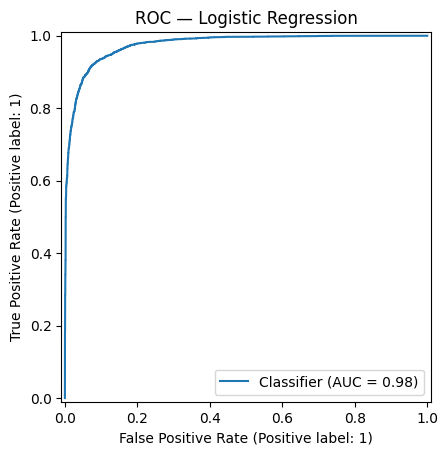

Logistic Regression: Acc=0.921  Prec=0.921  Rec=0.922  F1=0.921  AUC=0.976


In [6]:
evaluate_model("Logistic Regression", logreg, X_test, y_test, proba_ok=True, plot_roc=True)


In [7]:
rf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_split=4,
        class_weight="balanced_subsample", n_jobs=-1, random_state=42)),
])


In [8]:
rf.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


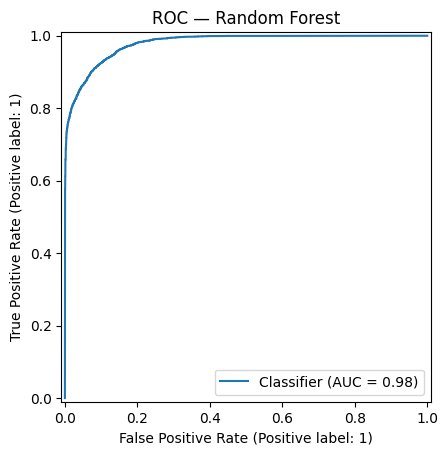

Random Forest: Acc=0.914  Prec=0.914  Rec=0.914  F1=0.914  AUC=0.979


In [9]:
evaluate_model("Random Forest", rf, X_test, y_test, proba_ok=True, plot_roc=True)


In [10]:
gb = Pipeline([
    ("prep", preprocessor),
    ("clf", GradientBoostingClassifier(
        learning_rate=0.05, n_estimators=400, max_depth=3, random_state=42)),
])


In [11]:
gb.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


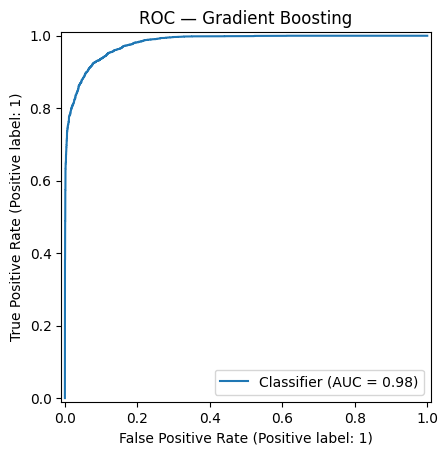

Gradient Boosting: Acc=0.922  Prec=0.920  Rec=0.925  F1=0.923  AUC=0.981


In [12]:
evaluate_model("Gradient Boosting", gb, X_test, y_test, proba_ok=True, plot_roc=True)


In [13]:
hgb = Pipeline([
    ("prep", preprocessor),
    ("clf", HistGradientBoostingClassifier(
        learning_rate=0.06, max_depth=None, max_bins=255, random_state=42)),
])


In [14]:
hgb.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


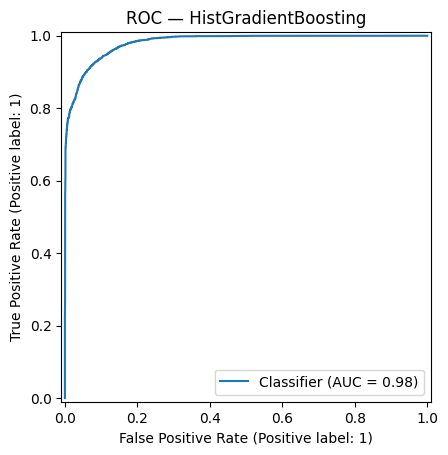

HistGradientBoosting: Acc=0.921  Prec=0.921  Rec=0.923  F1=0.922  AUC=0.982


In [15]:
evaluate_model("HistGradientBoosting", hgb, X_test, y_test, proba_ok=True, plot_roc=True)


In [16]:
linsvc = Pipeline([
    ("prep", preprocessor),
    ("clf", LinearSVC(C=1.0, class_weight="balanced", random_state=42)),
])


In [17]:
linsvc.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
evaluate_model("Linear SVC", linsvc, X_test, y_test, proba_ok=False, plot_roc=False)


Linear SVC: Acc=0.921  Prec=0.920  Rec=0.923  F1=0.921  AUC=NaN


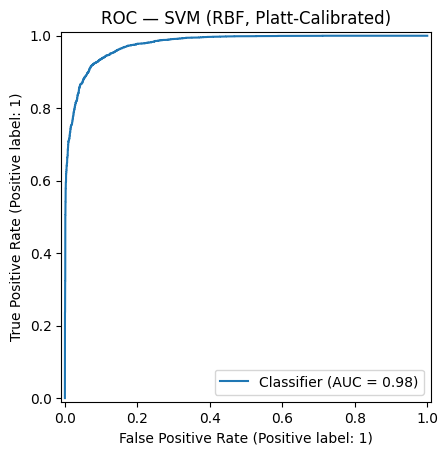

SVM (RBF, Platt-Calibrated): Acc=0.922  Prec=0.921  Rec=0.922  F1=0.922  AUC=0.978


In [36]:
#kernel svm
svm_rbf = Pipeline([
    ("prep", preprocessor),
    ("clf", CalibratedClassifierCV(
        estimator=SVC(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced"),
        cv=3  # Platt scaling
    )),
])

svm_rbf.fit(X_train, y_train)
evaluate_model("SVM (RBF, Platt-Calibrated)", svm_rbf, X_test, y_test, proba_ok=True, plot_roc=True)


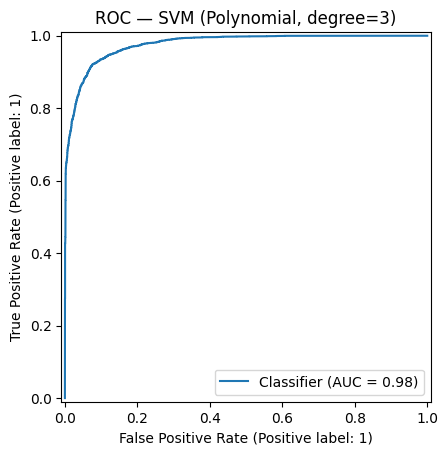

SVM (Polynomial, degree=3): Acc=0.921  Prec=0.920  Rec=0.923  F1=0.922  AUC=0.977


In [37]:
#poly svm 
svm_poly = Pipeline([
    ("prep", preprocessor),
    ("clf", CalibratedClassifierCV(
        estimator=SVC(kernel="poly", degree=3, C=1.0, class_weight="balanced"),
        cv=3
    )),
])

svm_poly.fit(X_train, y_train)
evaluate_model("SVM (Polynomial, degree=3)", svm_poly, X_test, y_test, proba_ok=True, plot_roc=True)


In [19]:
knn = Pipeline([
    ("prep", preprocessor),
    ("clf", KNeighborsClassifier(n_neighbors=25, weights="distance", p=2)),
])


In [20]:
knn.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [21]:
evaluate_model("KNN", knn, X_test, y_test, proba_ok=False, plot_roc=False)


KNN: Acc=0.913  Prec=0.914  Rec=0.913  F1=0.914  AUC=NaN


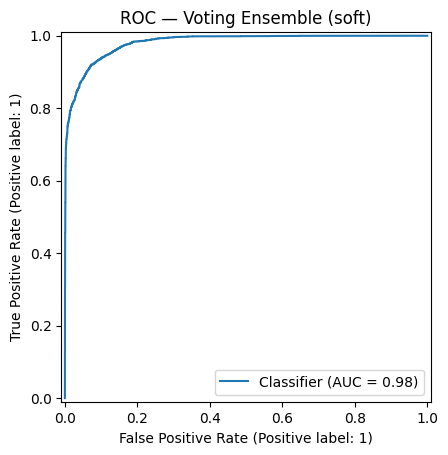

Voting Ensemble (soft): Acc=0.921  Prec=0.920  Rec=0.923  F1=0.921  AUC=0.981


In [38]:
#Voting ensemble soft voting, using probabilistic models
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ("logreg", logreg),
        ("rf", rf),
        ("gb", gb),
        ("hgb", hgb),
        ("svm_rbf", svm_rbf)
    ],
    voting="soft",
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
evaluate_model("Voting Ensemble (soft)", voting_clf, X_test, y_test, proba_ok=True, plot_roc=True)


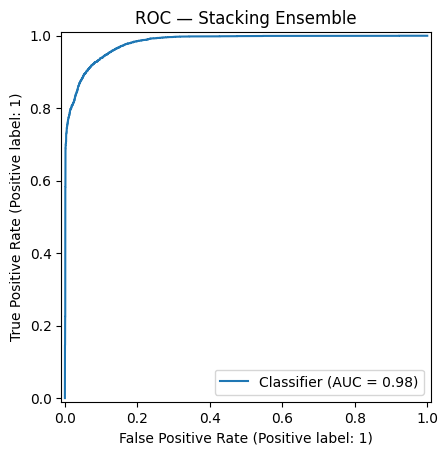

Stacking Ensemble: Acc=0.922  Prec=0.921  Rec=0.924  F1=0.922  AUC=0.981


In [40]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_clf = StackingClassifier(
    estimators=[
        ("logreg", logreg),
        ("rf", rf),
        ("gb", gb),
        ("hgb", hgb),
        ("svm_rbf", svm_rbf)
    ],
    final_estimator=LogisticRegression(max_iter=1000, class_weight="balanced"),
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)
evaluate_model("Stacking Ensemble", stacking_clf, X_test, y_test, proba_ok=True, plot_roc=True)


ValueError: Unknown format code 'f' for object of type 'str'

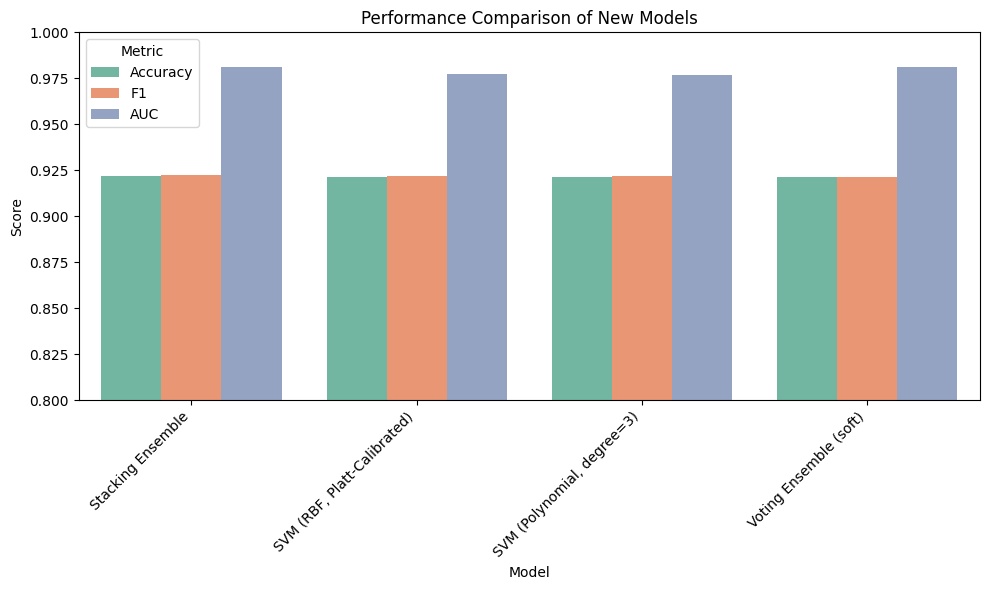

In [43]:
# Convert collected results into DataFrame
results_df = pd.DataFrame(results)

# Sort by accuracy (or AUC, your choice)
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Display neatly formatted table
display(results_df.style.format("{:.3f}"))

# --- Barplot for Accuracy, F1, and AUC ---
metrics_to_plot = ["Accuracy", "F1", "AUC"]
melted = results_df.melt(id_vars="Model", value_vars=metrics_to_plot,
                         var_name="Metric", value_name="Score")

plt.figure(figsize=(10,6))
sns.barplot(data=melted, x="Model", y="Score", hue="Metric", palette="Set2")
plt.xticks(rotation=45, ha="right")
plt.title("Performance Comparison of New Models")
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

In [23]:
import numpy as np

def get_feature_names_from_ct(preprocessor, num_cols, cat_cols):
    """Return column names after ColumnTransformer (num + OHE cat)."""
    # numeric names as-is
    out += list(num_cols)

    # categorical OHE names
    ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
    ohe_names = list(ohe.get_feature_names_out(cat_cols))
    out += ohe_names
    return np.array(out)


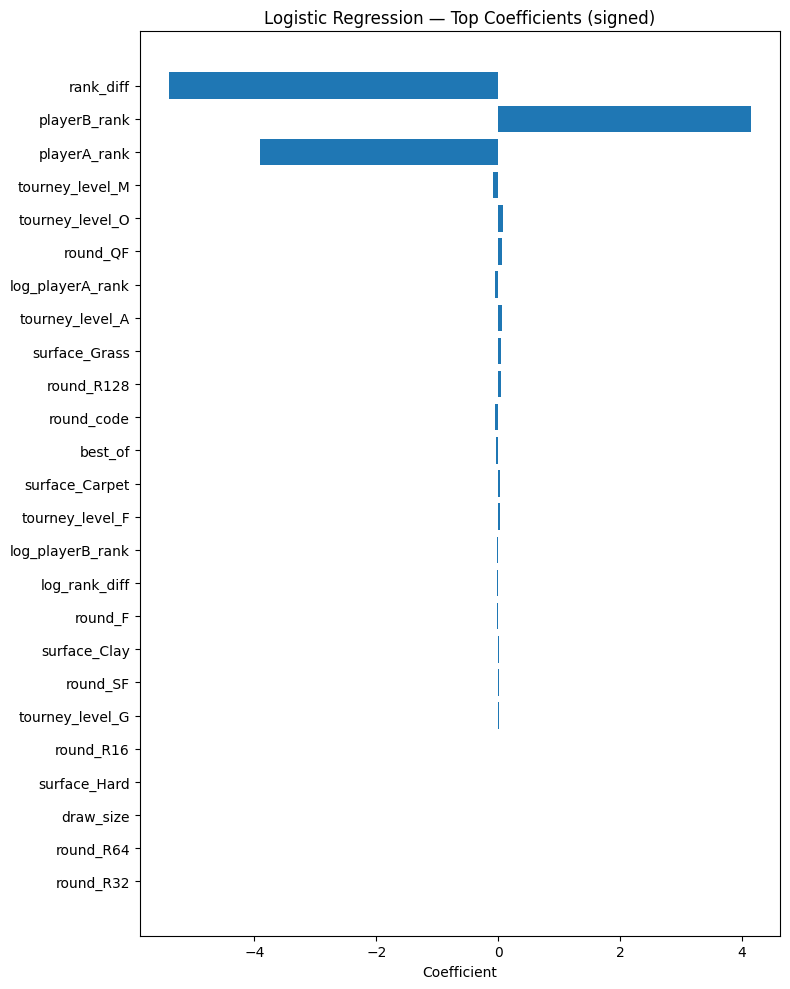

,feature,coef,abs_coef
5,rank_diff,-5.405325,5.405325
4,playerB_rank,4.143598,4.143598
3,playerA_rank,-3.910354,3.910354
24,tourney_level_M,-0.089319,0.089319
25,tourney_level_O,0.079506,0.079506
15,round_QF,0.063234,0.063234
6,log_playerA_rank,-0.062578,0.062578
21,tourney_level_A,0.058987,0.058987
12,surface_Grass,0.049812,0.049812
16,round_R128,0.048314,0.048314


In [24]:
# Build names exactly as the model sees them
feat_names = get_feature_names_from_ct(preprocessor, num_cols, cat_cols)

# Extract coefficients from the pipeline
lr_clf = logreg.named_steps["clf"]
lr_coef = lr_clf.coef_.ravel()
abs_order = np.argsort(np.abs(lr_coef))[::-1]

top_k = 25  # change as you like
top_idx = abs_order[:top_k]

plt.figure(figsize=(8, 10))
plt.barh(feat_names[top_idx][::-1], lr_coef[top_idx][::-1])
plt.title("Logistic Regression — Top Coefficients (signed)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

# Optional: show as a tidy table
imp_lr = (
    pd.DataFrame({"feature": feat_names, "coef": lr_coef, "abs_coef": np.abs(lr_coef)})
      .sort_values("abs_coef", ascending=False)
      .head(30)
)
display(imp_lr)


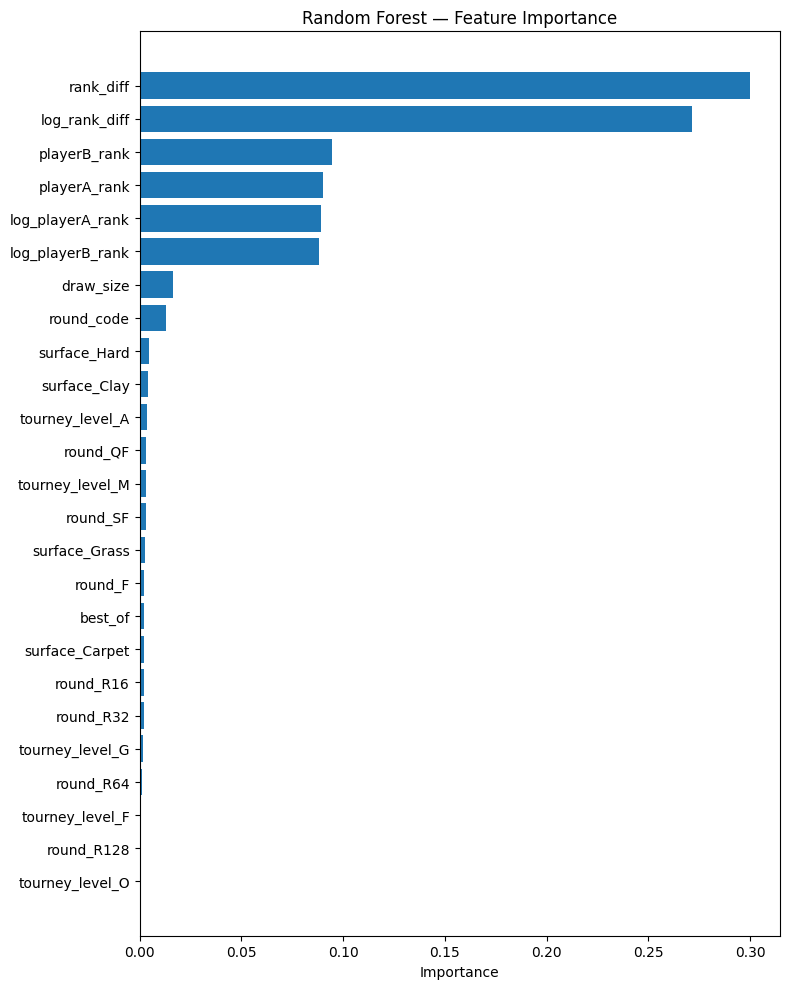

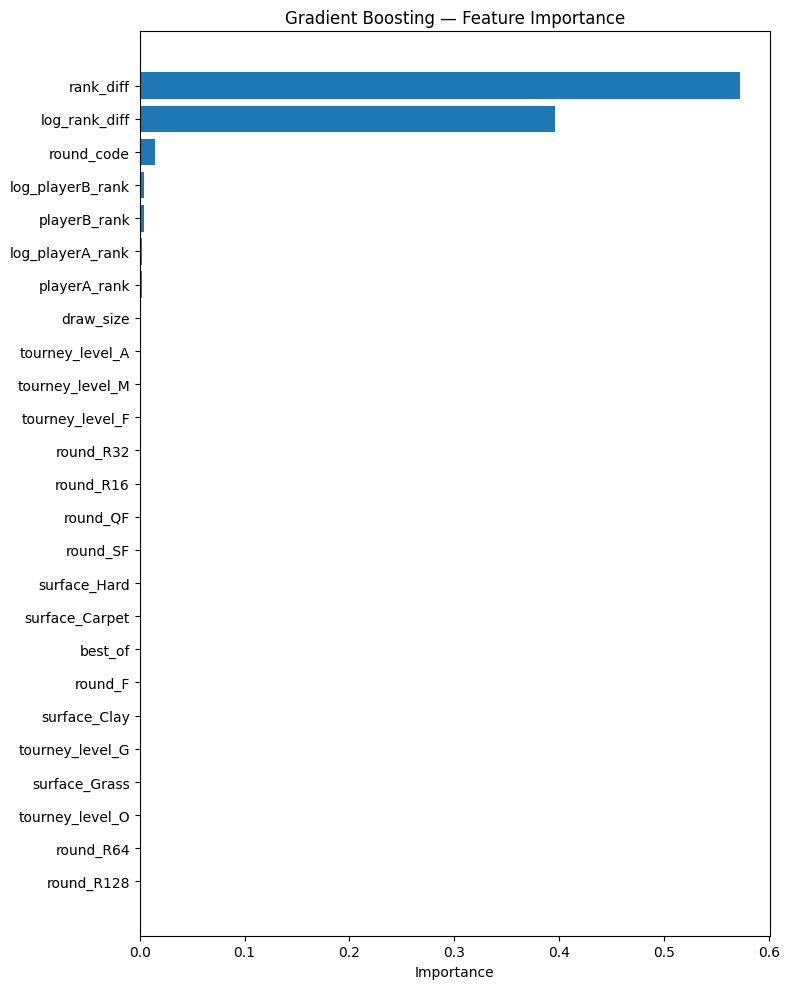

ValueError: This model has no attribute `feature_importances_`.

In [25]:
def plot_tree_importance(pipeline, title="Feature Importance (Tree Model)", top_k=25):
    feat_names = get_feature_names_from_ct(preprocessor, num_cols, cat_cols)
    clf = pipeline.named_steps["clf"]
    importances = getattr(clf, "feature_importances_", None)
    if importances is None:
        raise ValueError("This model has no attribute `feature_importances_`.")

    order = np.argsort(importances)[::-1][:top_k]
    plt.figure(figsize=(8, 10))
    plt.barh(feat_names[order][::-1], importances[order][::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# Examples:
plot_tree_importance(rf,  title="Random Forest — Feature Importance", top_k=25)
plot_tree_importance(gb,  title="Gradient Boosting — Feature Importance", top_k=25)
plot_tree_importance(hgb, title="HistGradientBoosting — Feature Importance", top_k=25)


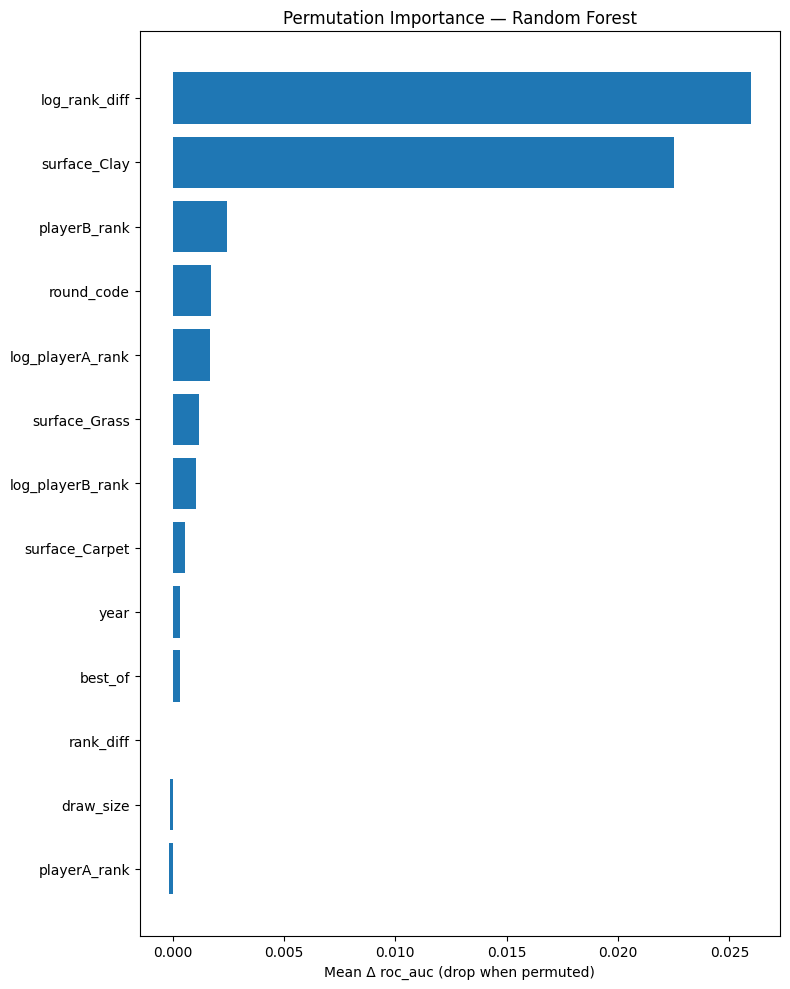

In [26]:
from sklearn.inspection import permutation_importance

def permutation_importance_plot(model, X_test, y_test, n_repeats=10, scoring="roc_auc", top_k=25, title=None):
    feat_names = get_feature_names_from_ct(preprocessor, num_cols, cat_cols)
    r = permutation_importance(model, X_test, y_test, n_repeats=n_repeats, scoring=scoring, random_state=42, n_jobs=-1)

    order = np.argsort(r.importances_mean)[::-1][:top_k]
    plt.figure(figsize=(8, 10))
    plt.barh(feat_names[order][::-1], r.importances_mean[order][::-1])
    plt.xlabel(f"Mean Δ {scoring} (drop when permuted)")
    plt.title(title or f"Permutation Importance — {type(model.named_steps['clf']).__name__}")
    plt.tight_layout()
    plt.show()

# Example with your chosen model
permutation_importance_plot(rf, X_test, y_test, scoring="roc_auc", top_k=25, title="Permutation Importance — Random Forest")


/home/stijn/api/venv/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column np.int64(5) contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/home/stijn/api/venv/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column np.int64(3) contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


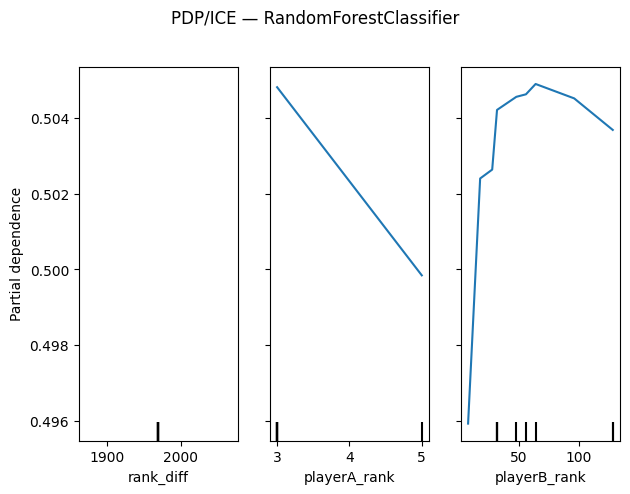

/home/stijn/api/venv/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column np.int64(5) contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/home/stijn/api/venv/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column np.int64(3) contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


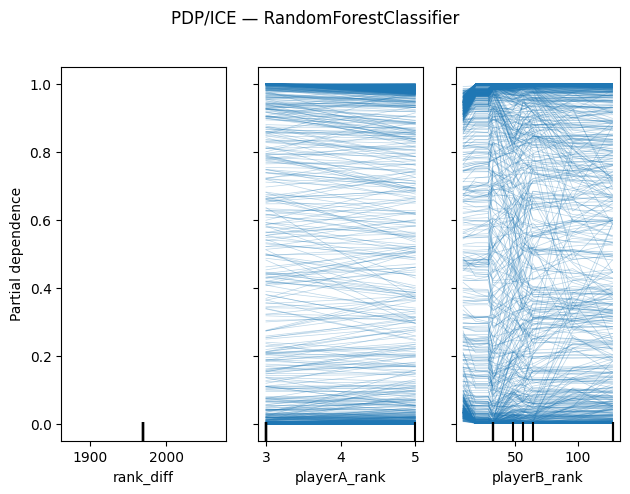

In [27]:
from sklearn.inspection import PartialDependenceDisplay

def plot_pdp(model, X_train, feature_names, targets, kind="average"):
    """
    targets: list of feature names to plot (must be in `feature_names`)
    kind: "average" (PDP) or "individual" (ICE) or "both"
    """
    # map names -> indices in transformed matrix
    idx = [np.where(feature_names == f)[0][0] for f in targets]
    PartialDependenceDisplay.from_estimator(
        model, X_train, features=idx, feature_names=feature_names, kind=kind,
        response_method="auto", grid_resolution=30
    )
    plt.suptitle(f"PDP/ICE — {type(model.named_steps['clf']).__name__}", y=1.02)
    plt.tight_layout()
    plt.show()

# Choose a fitted pipeline (tree models are often nicer for PDP)
chosen = rf

# Build feature names in transformed space
feat_names_tx = get_feature_names_from_ct(preprocessor, num_cols, cat_cols)

# Example PDP targets — adjust to what's in your data:
candidates = ["rank_diff", "playerA_rank", "playerB_rank", "log_rank_diff", "draw_size", "year"]
targets = [f for f in candidates if f in feat_names_tx][:3]  # take up to 3 that exist

plot_pdp(chosen, X_train, feat_names_tx, targets, kind="average")   # PDP
plot_pdp(chosen, X_train, feat_names_tx, targets, kind="individual")  # ICE curves


In [ ]:
try:
    import shap
    # Use a tree model for speed; sample if needed
    explainer = shap.Explainer(rf.named_steps["clf"])
    # Transform X_test through the preprocessor to get the actual matrix
    X_test_tx = preprocessor.transform(X_test)
    shap_values = explainer(X_test_tx)

    # Summary plot (global)
    shap.summary_plot(shap_values, features=X_test_tx, feature_names=get_feature_names_from_ct(preprocessor, num_cols, cat_cols), show=True)

    # Force plot for a single prediction (local)
    i = 0
    shap.plots.waterfall(shap_values[i], show=True)
except Exception as e:
    print("SHAP not available or failed to run:", e)


/home/stijn/api/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
